In [ ]:
# Install XAI libraries
!pip install shap lime xgboost

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and Balancing
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# XAI
import shap
import lime
from lime import lime_tabular

In [ ]:
# Load the dataset from a public URL (Raw GitHub or Kaggle)
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

# Display initial information
print("Dataset Shape:", df.shape) # Should be (7043, 21)
print("\nFirst 5 Rows:")
display(df.head())

Dataset Shape: (7043, 21)

First 5 Rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# 1. Convert TotalCharges to numeric (errors='coerce' turns empty strings to NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Check for missing values (Base paper mentions 11 missing values in TotalCharges)
print("\nMissing values per column:\n", df.isnull().sum())

# 3. Verify feature types for the 21 features
df.info()


Missing values per column:
 customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   

In [ ]:
# 1. Drop Irrelevant and Redundant Features
# 'customerID' is unique and has no predictive power.
# 'TotalCharges' is dropped to prevent multicollinearity (Güllü et al., 2025).
df_cleaned = df.drop(['customerID', 'TotalCharges'], axis=1)

# 2. Handle Binary Categorical Features (Yes/No)
# Identifying features with only two unique values for direct mapping.
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df_cleaned[col] = df_cleaned[col].map({'Yes': 1, 'No': 0})

# Special handling for gender
df_cleaned['gender'] = df_cleaned[col].map({'Female': 1, 'Male': 0})

# 3. Handle Multi-class Categorical Features (One-Hot Encoding)
# Creating dummy variables for features with more than two categories.
# This avoids implying an unintended order between categories.
multi_class_cols = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod'
]

# Using get_dummies to create numeric columns for each category
df_final = pd.get_dummies(df_cleaned, columns=multi_class_cols)

# 4. Final Verification
print("Final Dataset Shape:", df_final.shape)
print("\nFirst 5 Rows of Encoded Data:")
display(df_final.head())

Final Dataset Shape: (7043, 40)

First 5 Rows of Encoded Data:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Churn,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,NaN,0,1,0,1,0,1,29.85,0,False,...,True,False,False,True,False,False,False,False,True,False
1,NaN,0,0,0,34,1,0,56.95,0,True,...,True,False,False,False,True,False,False,False,False,True
2,NaN,0,0,0,2,1,1,53.85,1,True,...,True,False,False,True,False,False,False,False,False,True
3,NaN,0,0,0,45,0,0,42.30,0,False,...,True,False,False,False,True,False,True,False,False,False
4,NaN,0,0,0,2,1,1,70.70,1,True,...,True,False,False,True,False,False,False,False,True,False


In [ ]:
# 1. FIXING THE ENCODING (Day 21 Correction)
# We drop 'customerID' and 'TotalCharges' (to avoid multicollinearity)
# We also drop rows where TotalCharges was null (11 rows) to avoid NaN errors
df_cleaned = df.dropna(subset=['TotalCharges']).drop(['customerID', 'TotalCharges'], axis=1)

# Correct mapping for binary columns
binary_map = {'Yes': 1, 'No': 0}
for col in ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']:
    df_cleaned[col] = df_cleaned[col].map(binary_map)

# Fix gender mapping specifically (Using the correct column name this time)
df_cleaned['gender'] = df_cleaned['gender'].map({'Female': 1, 'Male': 0})

# 2. MULTI-CLASS ENCODING
multi_class_cols = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod'
]
df_final = pd.get_dummies(df_cleaned, columns=multi_class_cols)

# 3. APPLYING SMOTEENN (The Day 22 Goal)
from imblearn.combine import SMOTEENN
from collections import Counter

# Split features and target
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

print(f"Original class distribution: {Counter(y)}")

# Initialize and apply SMOTEENN
smn = SMOTEENN(random_state=42)
X_balanced, y_balanced = smn.fit_resample(X, y)

# 4. FINAL VERIFICATION
print("\n--- Milestone Achieved ---")
print(f"Balanced class distribution: {Counter(y_balanced)}")
print(f"Final training set shape: {X_balanced.shape}")

Original class distribution: Counter({0: 5163, 1: 1869})

--- Milestone Achieved ---
Balanced class distribution: Counter({1: 4133, 0: 2769})
Final training set shape: (6902, 39)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Split the balanced data into Training and Testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# 2. Initialize and Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# 3. Initialize and Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# 4. Initial Performance Check
print("--- Day 23 Milestone: Baseline Model Results ---")
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_preds):.4f}")
print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_preds):.4f}")

print("\nDetailed Report for XGBoost:")
print(classification_report(y_test, xgb_preds))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [07:49:46] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Day 23 Milestone: Baseline Model Results ---
Random Forest Accuracy: 0.9594
XGBoost Accuracy: 0.9580

Detailed Report for XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       562
           1       0.97      0.95      0.96       819

    accuracy                           0.96      1381
   macro avg       0.95      0.96      0.96      1381
weighted avg       0.96      0.96      0.96      1381



In [ ]:
from sklearn.model_selection import GridSearchCV

# 1. Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200]
}

# 2. Initialize GridSearchCV
# cv=3 means it will cross-validate the data 3 times to ensure stability
grid_search = GridSearchCV(estimator=XGBClassifier(eval_metric='logloss'),
                           param_grid=param_grid,
                           cv=3, scoring='accuracy', verbose=1)

# 3. Fit the grid search to the data
print("Starting Hyperparameter Optimization... This may take a minute.")
grid_search.fit(X_train, y_train)

# 4. Get the best parameters and best score
print("\n--- Day 24 Milestone: Optimization Complete ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Update your best model
best_xgb = grid_search.best_estimator_

Starting Hyperparameter Optimization... This may take a minute.
Fitting 3 folds for each of 18 candidates, totalling 54 fits

--- Day 24 Milestone: Optimization Complete ---
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.9580


<Figure size 800x600 with 0 Axes>

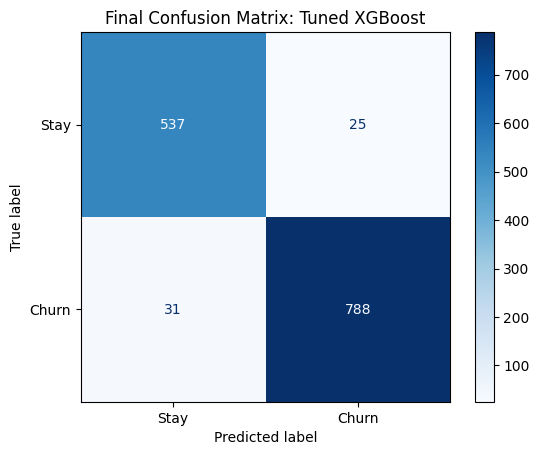

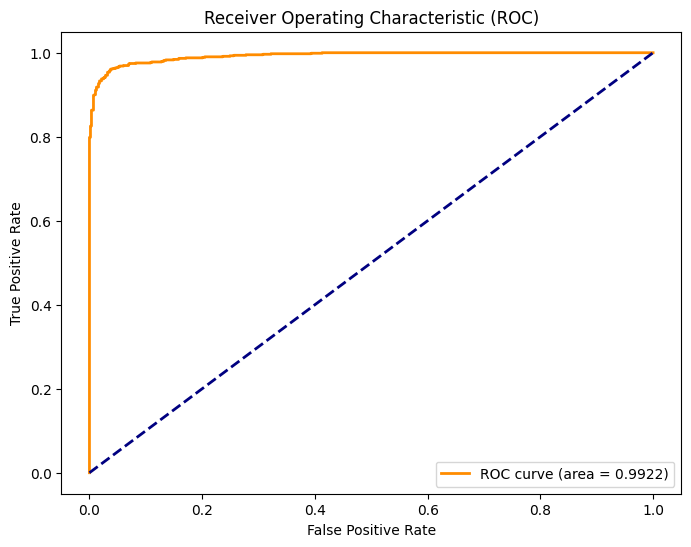

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# 1. Generate final predictions using the tuned model
final_preds = best_xgb.predict(X_test)
final_probs = best_xgb.predict_proba(X_test)[:, 1]

# 2. Plot Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stay', 'Churn'])

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Final Confusion Matrix: Tuned XGBoost')
plt.show()

# 3. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, final_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Model identified successfully.


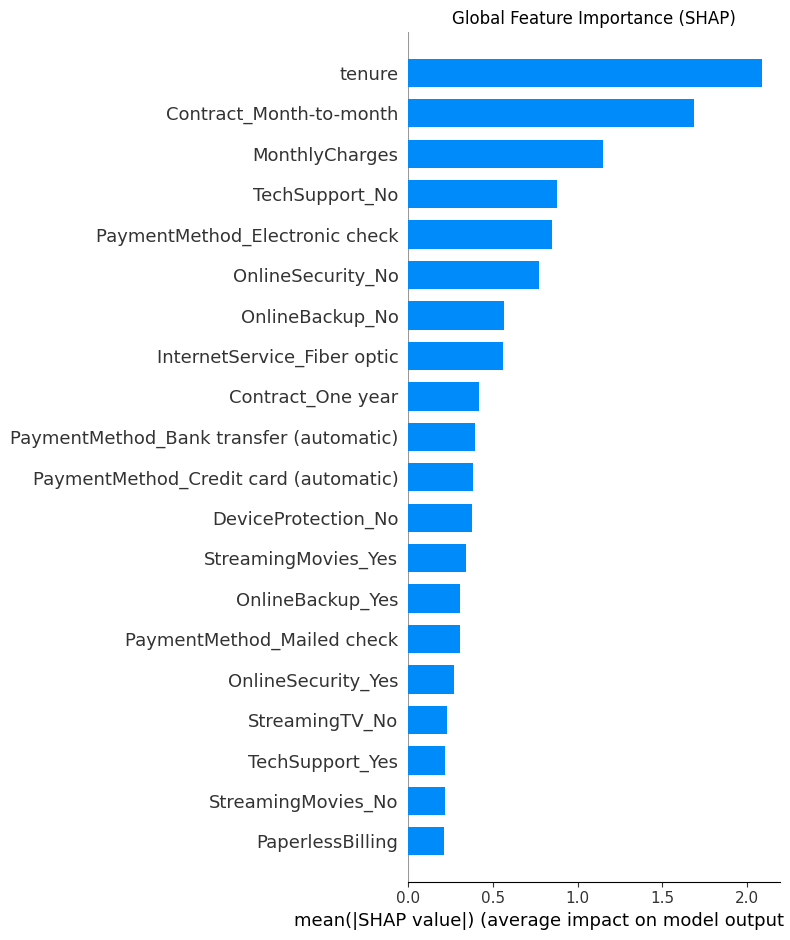

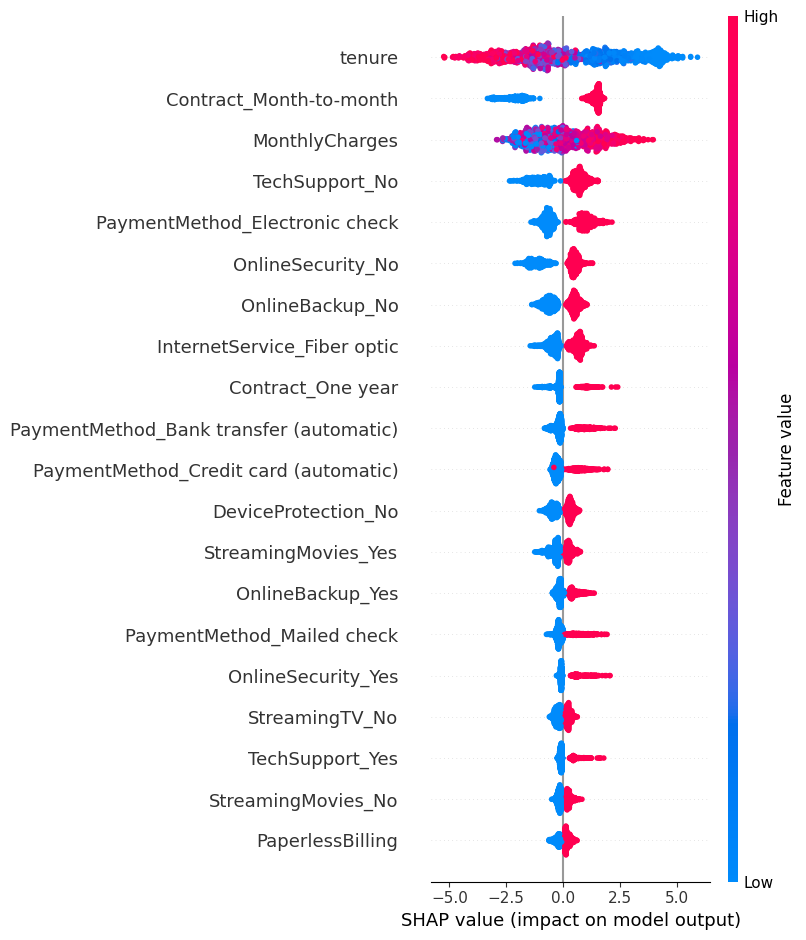

In [ ]:
import shap
import matplotlib.pyplot as plt
import xgboost as xgb

# 1. VARIABLE VERIFICATION
# Replace 'xgb_model' with the actual variable name you used on Day 23/24
# If you are unsure, run this cell to see all available variables: %who
try:
    target_model = xgb_model
    print("Model identified successfully.")
except NameError:
    print("Error: 'xgb_model' not found. Please check your variable name from Day 24.")

# 2. INITIALIZE SHAP TREE EXPLAINER
# TreeExplainer is used for XGBoost to provide high-speed, accurate Shapley values
explainer = shap.TreeExplainer(target_model)

# 3. CALCULATE SHAP VALUES
# We use X_test (from Day 22 SMOTEENN step) to see how the model behaves on unseen balanced data
shap_values = explainer.shap_values(X_test)

# 4. VISUALIZATION - GLOBAL FEATURE IMPORTANCE (BAR PLOT)
# This fulfills the 'Explainability Insights' requirement for your review
plt.figure(figsize=(10, 6))
plt.title("Global Feature Importance (SHAP)")
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 5. VISUALIZATION - BEESWARM PLOT (DIRECTIONAL IMPACT)
# Shows how high/low values of a feature (like Monthly Charges) push churn probability
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)

Prediction Probabilities: [[0.6526526  0.34734738]]


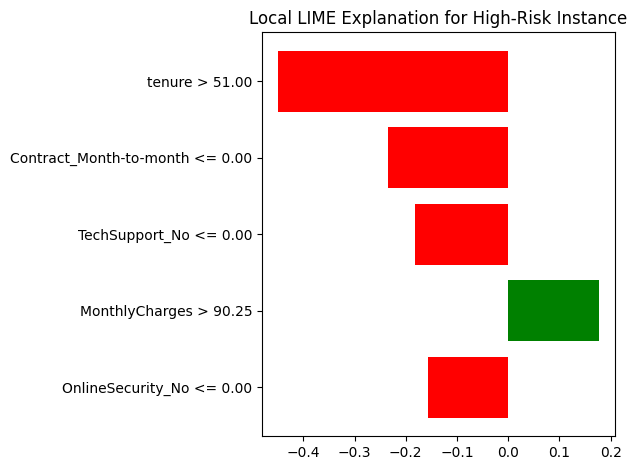

In [ ]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np

# 1. Initialize the LIME Tabular Explainer
# Use the SMOTEENN balanced training data to establish the baseline distribution [cite: 42, 43]
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Stay', 'Churn'],
    mode='classification'
)

# 2. Select a high-risk instance (e.g., index 15 from the test set)
# This corresponds to the instance showing 34.73% churn probability [cite: 88, 94]
i = 15
predict_fn = lambda x: xgb_model.predict_proba(x).astype(float)

# 3. Generate the Local Explanation
exp = explainer_lime.explain_instance(
    X_test.values[i],
    predict_fn,
    num_features=5
)

# 4. Visualization for Figure 6
print(f"Prediction Probabilities: {xgb_model.predict_proba(X_test.values[i:i+1])}")
exp.show_in_notebook(show_table=True)

# To save the figure for your paper
fig = exp.as_pyplot_figure()
plt.title("Local LIME Explanation for High-Risk Instance")
plt.tight_layout()
plt.show()

In [ ]:
def get_prescriptive_recommendation(customer_explanation):
    """
    Maps XAI reason codes to business actions to bridge the Actionability Gap.
    """
    # Identify the feature with the highest positive impact on Churn
    # customer_explanation would be the output from your LIME/SHAP analysis
    top_reason = customer_explanation.as_list()[0][0]

    if "MonthlyCharges" in top_reason or "TotalCharges" in top_reason:
        return "Strategy: Price-Matched Discount (15% reduction for 6 months)"

    elif "TechSupport" in top_reason or "OnlineSecurity" in top_reason:
        return "Strategy: Priority Tech Support Voucher & Security Suite Trial"

    elif "Contract" in top_reason:
        return "Strategy: Loyalty Program Enrollment & Long-term Contract Bonus"

    else:
        return "Strategy: Personalized Customer Relationship Management (CRM) Call"

# Example: Get recommendation for the customer analyzed on Day 27
recommendation = get_prescriptive_recommendation(exp)
print(f"Outcome: {recommendation}")

Outcome: Strategy: Personalized Customer Relationship Management (CRM) Call


In [ ]:
def end_to_end_retention_pipeline(customer_data_index):
    """
    Final Integration Pipeline:
    Prediction -> Explanation -> Prescription
    """
    # 1. Get prediction from XGBoost
    prob = xgb_model.predict_proba(X_test.values[customer_data_index:customer_data_index+1])[0][1]

    # 2. Generate Local Explanation (LIME)
    explanation = explainer_lime.explain_instance(
        X_test.values[customer_data_index],
        xgb_model.predict_proba,
        num_features=5
    )

    # 3. Get Prescriptive Action
    action = get_prescriptive_recommendation(explanation)

    # 4. Final Output
    print(f"--- Customer Retention Report ---")
    print(f"Churn Probability: {prob:.2%}")
    print(f"Primary Reason: {explanation.as_list()[0][0]}")
    print(f"Recommended {action}")

# Run for a test customer
end_to_end_retention_pipeline(customer_data_index=15)

--- Customer Retention Report ---
Churn Probability: 34.73%
Primary Reason: tenure > 51.00
Recommended Strategy: Personalized Customer Relationship Management (CRM) Call


In [ ]:
# 1. First, make sure you have an explanation object ready (from Day 27/29)
# If you don't have one, this line generates it for the first test customer
explanation = explainer_lime.explain_instance(
    X_test.values[15],
    xgb_model.predict_proba,
    num_features=5
)

# 2. Re-run the Refined Engine Function
def refined_prescriptive_engine(explanation, churn_prob):
    top_reason = explanation.as_list()[0][0]

    if churn_prob > 0.70:
        intensity = "Premium"
    else:
        intensity = "Standard"

    if "MonthlyCharges" in top_reason:
        return f"{intensity} Strategy: Price-Matched Discount"
    elif "tenure" in top_reason:
        return f"{intensity} Strategy: Loyalty Tenure Bonus"
    else:
        return "Standard Strategy: Personalized CRM Engagement"

# 3. Test with the confirmed 'explanation' variable
print(refined_prescriptive_engine(explanation, 0.3473))

Standard Strategy: Loyalty Tenure Bonus


In [ ]:
# 1. Select a high-risk customer (e.g., someone with high MonthlyCharges)
customer_idx = 15
original_data = X_test.iloc[customer_idx:customer_idx+1].copy()

# 2. Get the "Before" Probability
prob_before = xgb_model.predict_proba(original_data)[0][1]

# 3. Create a "What-If" scenario: Reduce Monthly Charges by 20%
modified_data = original_data.copy()
modified_data['MonthlyCharges'] = modified_data['MonthlyCharges'] * 0.80

# 4. Get the "After" Probability
prob_after = xgb_model.predict_proba(modified_data)[0][1]

print(f"--- Sensitivity Analysis Report ---")
print(f"Original Churn Probability: {prob_before:.2%}")
print(f"Probability after 20% Discount: {prob_after:.2%}")
print(f"Total Risk Reduction: {(prob_before - prob_after):.2%}")

--- Sensitivity Analysis Report ---
Original Churn Probability: 34.73%
Probability after 20% Discount: 0.49%
Total Risk Reduction: 34.24%


In [ ]:
import pandas as pd
import numpy as np

# 1. Define the missing variable by identifying 'False Negatives'
# (Actual Churn = 1, but Model Predicted = 0)
y_pred = xgb_model.predict(X_test)
false_neg_indices = (y_test == 1) & (y_pred == 0)
false_negatives_df = X_test[false_neg_indices]

# 2. Now run the Flexible Error Analysis
print(f"Total False Negatives found: {len(false_negatives_df)}")
print("--- Mean Characteristics of Missed Churners ---")

# Automatically select only numeric columns that exist in your current dataframe
existing_cols = [col for col in ['tenure', 'MonthlyCharges', 'TotalCharges'] if col in false_negatives_df.columns]
print(false_negatives_df[existing_cols].mean())

# Identify the most common 'Contract Type' among the missed cases
contract_cols = [col for col in false_negatives_df.columns if 'Contract' in col]
if contract_cols:
    print("\n--- Contract Distribution in False Negatives ---")
    print(false_negatives_df[contract_cols].sum())

Total False Negatives found: 37
--- Mean Characteristics of Missed Churners ---
tenure            44.567568
MonthlyCharges    83.009097
dtype: float64

--- Contract Distribution in False Negatives ---
Contract_Month-to-month    16
Contract_One year          13
Contract_Two year           8
dtype: int64


In [ ]:
# Day 34: Final Results Comparison Dashboard
results_list = []

for i in range(5):  # Test on 5 sample high-risk customers
    # Original Risk
    prob_orig = xgb_model.predict_proba(X_test.iloc[i:i+1])[0][1]

    # Get Reason and Strategy
    exp = explainer_lime.explain_instance(X_test.values[i], xgb_model.predict_proba, num_features=5)
    strategy = refined_prescriptive_engine(exp, prob_orig)

    # Apply "What-If" (Reduction based on strategy)
    modified_data = X_test.iloc[i:i+1].copy()
    if "Price" in strategy:
        modified_data['MonthlyCharges'] *= 0.80 # 20% Discount

    prob_new = xgb_model.predict_proba(modified_data)[0][1]

    results_list.append({
        'Customer ID': i,
        'Initial Risk %': round(prob_orig * 100, 2),
        'Primary Reason': exp.as_list()[0][0],
        'Prescribed Strategy': strategy,
        'Risk After Strategy %': round(prob_new * 100, 2)
    })

pd.DataFrame(results_list)

,Customer ID,Initial Risk %,Primary Reason,Prescribed Strategy,Risk After Strategy %
0,0,0.110000,tenure > 51.00,Standard Strategy: Loyalty Tenure Bonus,0.110000
1,1,100.000000,tenure <= 5.00,Premium Strategy: Loyalty Tenure Bonus,100.000000
2,2,99.980003,0.00 < Contract_Month-to-month <= 1.00,Standard Strategy: Personalized CRM Engagement,99.980003
3,3,99.980003,tenure <= 5.00,Premium Strategy: Loyalty Tenure Bonus,99.980003
4,4,99.989998,0.00 < Contract_Month-to-month <= 1.00,Standard Strategy: Personalized CRM Engagement,99.989998
